1) Przypomnienie zwykłego clusteringu
* k-means
* PAM?

2) Co to jest ensamble clustering
* Generation step
* Consensus step
* Cechy dobrego modelu

3) Przykładowe modele

4) Case study

In [1]:
from sklearn.datasets import make_moons, make_blobs
import numpy as np
import matplotlib.pyplot as plt

In [9]:
from sklearn.datasets import make_moons, make_blobs
np.random.seed(214)
X_moons, Y_moons = make_moons(n_samples=350, noise=0.1, random_state=214)
X_blobs, Y_blobs = make_blobs(n_samples=80, centers=[[-0.5,-0.5]], cluster_std=0.2, random_state=214)
Y_blobs += 2
X_noise = np.random.uniform(low=-1.5, high=2.0, size=(100,2))

X_vectors = np.vstack([X_moons, X_blobs, X_noise])
Y_vectors = np.concatenate([Y_moons, Y_blobs, -np.ones(100)])

problematic_x = np.vstack([X_moons, X_blobs, X_noise])
problematic_y = np.concatenate([Y_moons, Y_blobs, -np.ones(100)])

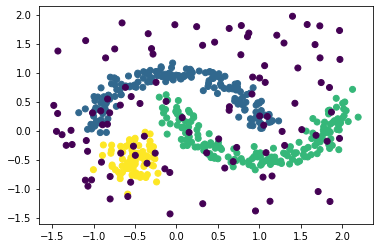

In [10]:
plt.scatter(problematic_x[:, 0], problematic_x[:, 1], c=problematic_y)
plt.show()

In [20]:
# Number of bootstrap samples
B = 30

# Number of clusters (optional, can be determined by the algorithm)
k = 3

# Parameters for the KMeans algorithm (optional)
parameters = {"init": "random", "n_init": 1}

# Call the cl_bag function
pred_y = cl_bag(problematic_x, B, k, algorithm='kmeans', parameters=parameters)


c:\Users\kaami\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\kaami\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\kaami\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\kaami\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Window

# Dataset creation

In [81]:
def plot_points(dataset, labels=None):
    if labels is None:
        labels = 'cornflowerblue'
    plt.figure(figsize=(8, 8))
    plt.grid(alpha=0.4)
    plt.scatter(dataset[:, 0], dataset[:, 1], c=labels)
    # plt.xticks([])
    # plt.yticks([])
    
    plt.show()

(500, 2)


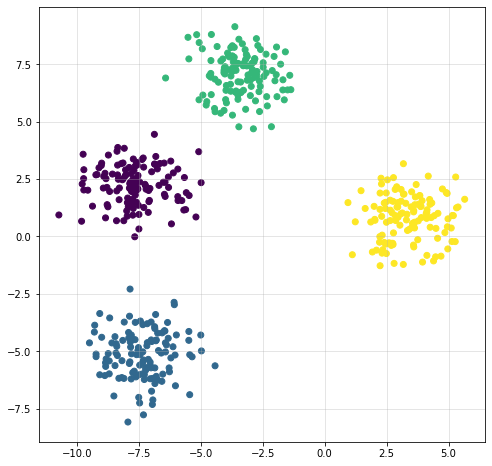

In [88]:
dataset_easy, labels = make_blobs(n_samples=500, n_features=2, centers=4, random_state=43)
print(dataset_easy.shape)
plot_points(dataset_easy, labels)

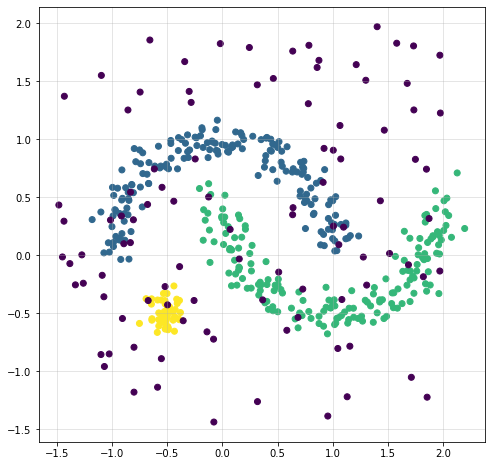

In [84]:
np.random.seed(214)

X_moons, y1 = make_moons(n_samples=350, noise=0.1, random_state=214)
X_blobs, y2 = make_blobs(n_samples=50, centers=[[-0.5,-0.5]], cluster_std=[0.1], random_state=214)
y2 += 2
X_noise = np.random.uniform(low=-1.5, high=2.0, size=(100,2))

dataset_hard = np.vstack([X_moons, X_blobs, X_noise])
labels = np.concatenate([y1, y2, -np.ones(100)])
plot_points(dataset_hard, labels)

(500, 2)


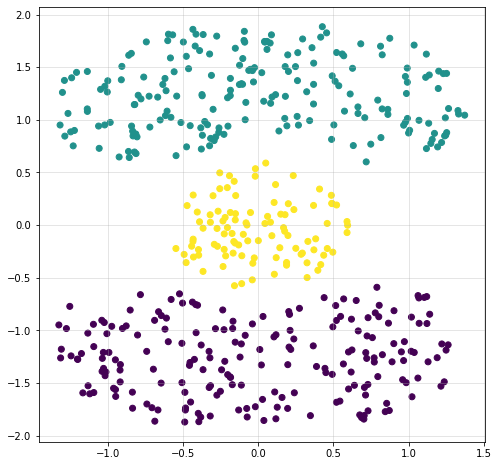

In [85]:
dataset_cassini = np.loadtxt('cassini.csv', delimiter=';')
labels = np.loadtxt('cassini_labels.csv')
print(dataset_cassini.shape)
plot_points(dataset_cassini, labels)

In [91]:
def plot_three_datasets(labels1, labels2, labels3, dataset1=dataset_easy, dataset2=dataset_hard, dataset3=dataset_cassini):
    plt.figure(figsize=(18, 6))
    
    plt.subplot(1, 3, 1)
    plt.grid(alpha=0.4)
    plt.scatter(dataset1[:, 0], dataset1[:, 1], c=labels1)
    plt.title("Easy Dataset")
    
    plt.subplot(1, 3, 2)
    plt.grid(alpha=0.4)
    plt.scatter(dataset2[:, 0], dataset2[:, 1], c=labels2)
    plt.title("Hard Dataset")
    
    plt.subplot(1, 3, 3)
    plt.grid(alpha=0.4)
    plt.scatter(dataset3[:, 0], dataset3[:, 1], c=labels3)
    plt.title("Cassini Dataset")
    
    plt.show()

c:\Users\kaami\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\kaami\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\kaami\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


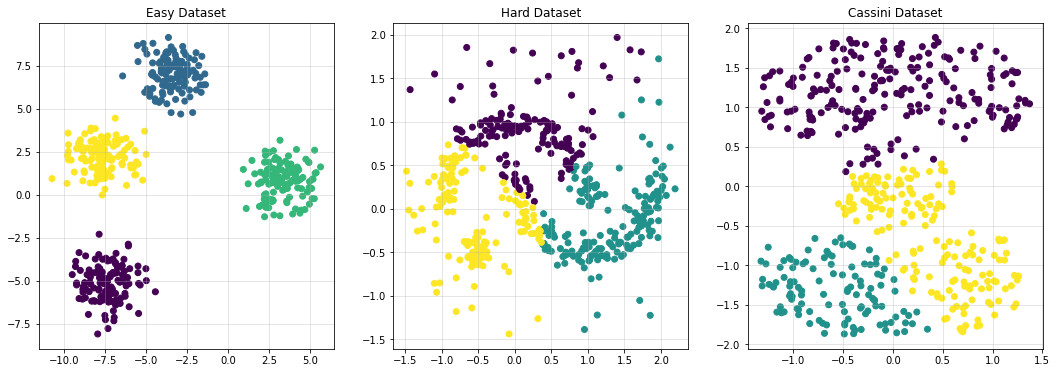

In [106]:
from sklearn.cluster import KMeans
parameters = {'n_init': 10, 'max_iter': 300}
D1 = KMeans(n_clusters=4, **parameters).fit(dataset_easy).labels_
D2 = KMeans(n_clusters=3, **parameters).fit(dataset_hard).labels_
D3 = KMeans(n_clusters=3, **parameters).fit(dataset_cassini).labels_

plot_three_datasets(D1, D2, D3)

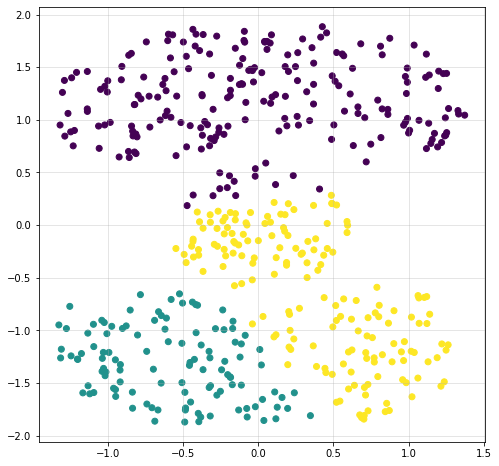

In [107]:
plot_points(dataset_cassini, D3)